In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import MazeEnv as mz
from MazeEnv import Rewards
import time
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from Evaluation import EvalAndSaveCallback, moving_average
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt

import torch
torch.cuda.is_available()

pybullet build time: May 25 2021 20:16:47


True

In [13]:
def make_circular_map(size, radius):
    center = np.divide(size, 2)
    x, y = np.ogrid[:size[0], :size[1]]
    maze_map = np.where(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) > radius, 1, 0)

    return maze_map

In [14]:
START_LOC = (5, 3)
TIMEOUT_STEPS = 200
BUFFER_SIZE = 10**4 # smaller buffer for small task
TOTAL_TIME_STEPS = 1*10**4
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5)

EVAL_EPISODES=5
EVAL_FREQ=500
VIDEO_FREQ=4

In [17]:
# create environment :
tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 3.5 / tile_size)
# maze_map = np.zeros(map_size)

maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                              maze_map=maze_map,
                              tile_size=tile_size,
                              start_loc=START_LOC,
                              target_loc=np.divide(maze_size, 2),
                              timeout_steps=TIMEOUT_STEPS,
                              show_gui=False,
                              rewards=REWARDS), 
                  filename="logs/DummyMaze/results")
_ = maze_env.reset()

# create separete evaluation environment:
eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=np.divide(maze_size, 2),
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = eval_maze_env.reset()
 
# create model:
model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device='cuda',
             train_freq=(1, "episode"),
             verbose=1)

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/DummyMaze",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=1)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [18]:
start = time.time()

model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback,)

print("time", time.time() - start)

500 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
--Saving new best smodel--
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -0.5     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 262      |
|    time_elapsed    | 3        |
|    total timesteps | 800      |
| train/             |          |
|    actor_loss      | -0.145   |
|    critic_loss     | 0.00173  |
|    learning_rate   | 0.001    |
|    n_updates       | 600      |
---------------------------------
1000 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
1500 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -0.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 219      |
|    time_elapsed    | 7    

Text(0.5, 0, 'Step')

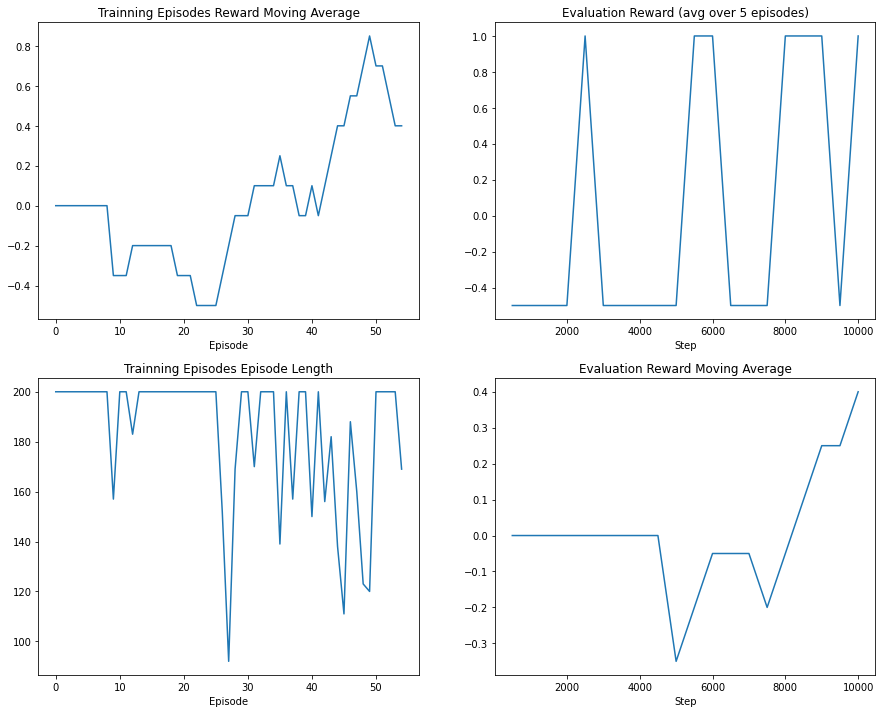

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))

results_df = pd.read_csv("logs/DummyMaze/results.monitor.csv", header=1)
eval_results_df = pd.read_csv("logs/DummyMaze/eval_results.csv",
                         names=["Step", "Avg Reward", "Avg Episode Length"],
                         index_col=0)

episode = results_df.index.to_numpy()
reward = results_df["r"].to_numpy()
reward_moving_avg = moving_average(reward, kernel_size=10)
episode_length= results_df["l"].to_numpy()

axes[0, 0].plot(episode, reward_moving_avg)
axes[0, 0].set_title("Trainning Episodes Reward Moving Average")
axes[0, 0].set_xlabel("Episode")

axes[1, 0].plot(episode, episode_length)
axes[1, 0].set_title("Trainning Episodes Episode Length")
axes[1, 0].set_xlabel("Episode")


eval_results_df.plot(y="Avg Reward", ax=axes[0,1], legend=None)
axes[0, 1].set_title("Evaluation Reward (avg over {eval_episodes} episodes)".format(eval_episodes=EVAL_EPISODES))

steps = eval_results_df.index.to_numpy()
eval_reward = eval_results_df["Avg Reward"].to_numpy()
eval_reward_moving_avg = moving_average(eval_reward, kernel_size=10)
axes[1, 1].plot(steps, eval_reward_moving_avg)
axes[1, 1].set_title("Evaluation Reward Moving Average")
axes[1, 1].set_xlabel("Step")



In [31]:
# load best model 
best_model = DDPG.load("./logs/DummyMaze/best_model")

# evaluate the best model
episode_reward = 0
obs = eval_maze_env.reset(create_video=True, video_path="logs/DummyMaze/final.avi")
while True:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, _ = eval_maze_env.step(action)
    episode_reward += reward
    if done:
        print("Reward:", episode_reward)
        break
        


Reward: 1


In [40]:
# run this before calling Video()
! ln -sf "./logs/DummyMaze/10000_steps.avi" ./10000_steps.avi

In [ ]:
!pip install ipywidgets

In [54]:
#from IPython.display import display, HTML,Video
from ipywidgets import Video

# Video("10000_steps.avi", width=700, height=576)
# Video.from_file("./logs/DummyMaze/10000_steps.avi", width=320, height=320, play=True)


Video(value=b'RIFF\xcc\x0b\x01\x00AVI LIST\xec\x11\x00\x00hdrlavih8\x00\x00\x00\xc2\xa2\x00\x00\x00\xa6\x0e\x0…

In [4]:
# %%HTML
# <video width=700 controls>
#     <source src="./logs/DummyMaze/10000_steps_check.avi" type="video/avi">
# </video>

from IPython.display import HTML

HTML("""
<video width=700 controls>
    <source src="./logs/DummyMaze/10000_steps_check.avi" type="video/avi">
</video>""")

In [26]:
maze_env = mz.MazeEnv(maze_size=maze_size,
                      maze_map=maze_map,
                      tile_size=tile_size,
                      start_loc=START_LOC,
                      target_loc=np.divide(maze_size, 2),
                      timeout_steps=TIMEOUT_STEPS,
                      show_gui=False)

from stable_baselines3.common.env_checker import check_env
check_env(maze_env)